# DDA walkthrought example: Chua attractor

What follows is an example of the Chua attractor. It is described in the [Analog Paradigm Application Note 3](http://analogparadigm.com/downloads/alpaca_3.pdf) as well as in section 6.15 in Bernd's new book (Analog Programming II). The attractor is described by a coupled set of three ordinary differential equations,

$$
  \dot x = c_1 (y-x-f(x)) \\
  \dot y = c_2 (x-y+z) \\
  \dot z = -c_3 y
$$

with $f(x)$ a simple function decribing the Chua diode (given algebraically) and a number of parameters $c_{1,2,3}$. What follows is the scaling of these equations. The resulting set of equations is slightly more verbose. It's implementation is given in the following *traditional DDA* file:

In [1]:
!cat chua.dda

#
# Copyright (c) 2020 anabrid GmbH
# Contact: https://www.anabrid.com/licensing/
#
# This file is part of the examples of the PyAnalog toolkit.
#
# ANABRID_BEGIN_LICENSE:GPL
# Commercial License Usage
# Licensees holding valid commercial anabrid licenses may use this file in
# accordance with the commercial license agreement provided with the
# Software or, alternatively, in accordance with the terms contained in
# a written agreement between you and Anabrid GmbH. For licensing terms
# and conditions see https://www.anabrid.com/licensing. For further
# information use the contact form at https://www.anabrid.com/contact.
# 
# GNU General Public License Usage
# Alternatively, this file may be used under the terms of the GNU 
# General Public License version 3 as published by the Free Software
# Foundation and appearing in the file LICENSE.GPL3 included in the
# packaging of this file. Please review the following information to
# ensure the GNU General Public License version 3 requiremen

In the following, we use the PyDDA library to read in this DDA file and demonstrate the internal representation.

In [2]:
from dda.dsl import read_traditional_dda
chua_text = open("chua.dda").read()
state = read_traditional_dda(chua_text)
state

State({'dt': const(0.001),
 'f1': abs(sum(mult(0.7143, x), 0.2857)),
 'f2': abs(sum(mult(0.7143, x), -0.2857)),
 'f3': neg(sum(f1, neg(f2))),
 'fx': sum(mult(0.714, x), mult(0.3003, f3)),
 'x': neg(sum(mult(3.12, neg(int(x2, dt, 0))), x0)),
 'x0': const(0.1),
 'x1': mult(-10, neg(sum(x, fx))),
 'x2': neg(sum(y, mult(0.5, x1))),
 'y': mult(4, neg(int(y2, dt, 0))),
 'y1': neg(sum(z, neg(mult(0.125, y)))),
 'y2': neg(sum(mult(1.25, x), mult(2, y1))),
 'z': int(mult(3.5, y), dt, 0)})

## Syntax trees: Down into the rabbit hole

Obviously, the output of the internal data structure *state* and the DDA file itself does not differ so much. That is by intention, both look quite pythonic. The state itself is basically a dictionary (mapping) from strings (the left hand sides in the DDA file) to the expressions (their right hand sides). Let's inspect such an expression.

In [3]:
state["z"]

int(mult(3.5, y), dt, 0)

In [4]:
type(state["z"])

dda.ast.Symbol

In [5]:
print(state["z"].head)
print(state["z"].tail)

int
(mult(3.5, y), dt, 0)


What we are actually looking at is the PyDDA-representation of a mathematical expression tree. We can visualize this tree:

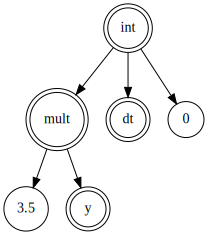

In [6]:
state["z"].draw_graph()

Given this, we can compute the dependencies of all variables in the sytem:

In [7]:
graph = state.draw_dependency_graph(export_dot=False)
graph

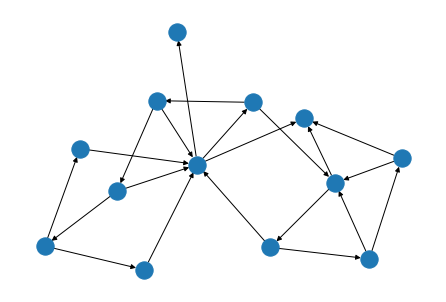

In [9]:
# Draw the graph with matlotlib
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(graph)
nx.draw(graph, pos=pos)

In [10]:
# draw the graph with graphviz (requires pydot,graphviz)
from networkx.drawing.nx_pydot import to_pydot
from graphviz import Source
nx2dot = lambda graph: Source(to_pydot(graph).to_string())

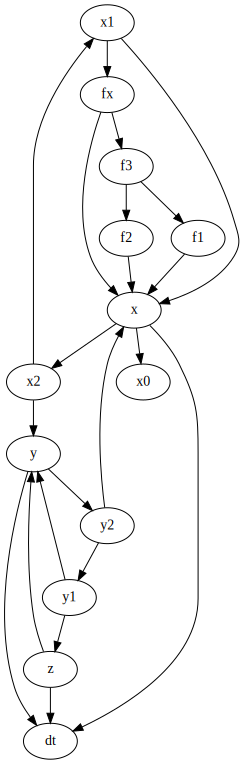

In [11]:
nx2dot(graph)

Based on this dependency analysis, one can *linearize* the state, that is, define an ordering how to compute the state numerically:

In [12]:
vars = state.variable_ordering()

In [13]:
print("The evolved variables are:", vars.evolved)
print("Auxilliary variables are:", vars.aux.all)

The evolved variables are: ['int_1', 'int_2', 'z']
Auxilliary variables are: ['f1', 'f2', 'f3', 'fx', 'mult_10', 'mult_6', 'mult_9', 'sum_1', 'sum_2', 'sum_3', 'sum_4', 'sum_5', 'sum_6', 'sum_7', 'sum_8', 'x', 'x1', 'x2', 'y', 'y1', 'y2']


One sees a number of new variables. They were introduced by *naming* all *intermediate* expressions. What are these intermediates? Let's review again the variable *z*:

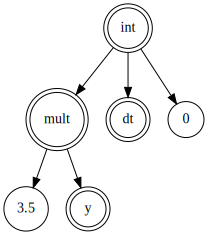

In [14]:
state["z"].draw_graph()

Here, the left most child is an intermediate expression, since it computes `mult(3.5, y)`. We can give this intermediate result a concrete name and replace the whole subtree with this name:

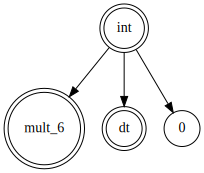

In [15]:
state.name_computing_elements()["z"].draw_graph()

## Simulating a circuit

In the following, we use the C++ code generator to simulate this simple ordinary differential equation:

In [29]:
cpp_code = state.export(to="C")
print(cpp_code[:1000])
print("// ... (in total ", cpp_code.count("\n"), " lines of C/C++ code) ...")

// This code was generated by PyDDA.

#include <cmath> /* don't forget -lm for linking */
#include <cfenv> /* for feraisexcept and friends */
#include <limits> /* for signaling NAN */
#include <vector>
#include <string>
#include <sstream>
#include <algorithm>
#include <map>
#include <cstdio>
#include <iostream>
#include <fstream>

bool debug;
constexpr double _nan_ = std::numeric_limits<double>::signaling_NaN();

namespace dda {

/* if you use an old C++ compiler, just remove the newer features */
#define A constexpr double            /* constexpr requires C++11 */
#define D template<typename... T> A   /* Variadic templates require C++17 */

// Known limitations for div(int, double): If certain arguments appear as integer
// in the code (i.e. 1 instead of 1.0), there is div(int,int) kicking in from
// cstdlib. TODO: Should rename div to Div; following int->Int.

A neg(double a) { return -a; }
A div(double a, double b) { return a/b; }
D Int(T... a) { return -(a + ...); } // int() is res

We printed the generated C++ code, which is in fact just a string in python, in the cell above. Next come some shortcut functions which call the system C++ compiler and run the binary, all externally on the system shell. The return value is slurped in as CSV data with numpy, so we readily have it for plotting.

In [30]:
from dda.cpp_exporter import compile, run
compile(cpp_code)

In [31]:
# This shows the stdout of the binary generated by the above C++ code:
print(run(arguments={"max_iterations":10}, fields_to_export=list("xyz"), return_ndarray=False))

Running: ./a.out --max_iterations=10 x y z
x	y	z
0.100223	0.0005	0
0.100448	0.00100062	-1.75e-06
0.100675	0.00150184	-5.25215e-06
0.100905	0.00200368	-1.05086e-05
0.101136	0.00250611	-1.75215e-05
0.10137	0.00300915	-2.62929e-05
0.101605	0.00351277	-3.68249e-05
0.101843	0.00401699	-4.91196e-05
0.102082	0.0045218	-6.3179e-05
0.102324	0.00502718	-7.90053e-05



In [32]:
# We can slurp in the CSV data directly to a numpy recarray:
result = run(arguments={"max_iterations":1000, "modulo_write":10})

Running: ./a.out --max_iterations=1000 --modulo_write=10


In [33]:
result["x"]

array([0.100223, 0.102568, 0.105126, 0.107902, 0.110904, 0.114137,
       0.11761 , 0.121327, 0.125297, 0.129525, 0.134019, 0.138785,
       0.143831, 0.149164, 0.154792, 0.16072 , 0.166958, 0.173512,
       0.180391, 0.187603, 0.195156, 0.203058, 0.211319, 0.219946,
       0.22895 , 0.23834 , 0.248125, 0.258317, 0.268924, 0.279959,
       0.291432, 0.303354, 0.315739, 0.328597, 0.341943, 0.355789,
       0.370149, 0.385039, 0.400471, 0.415958, 0.430975, 0.445545,
       0.459687, 0.473419, 0.486757, 0.499714, 0.512304, 0.524535,
       0.536418, 0.54796 , 0.559167, 0.570045, 0.580597, 0.590828,
       0.600738, 0.61033 , 0.619603, 0.628559, 0.637196, 0.645513,
       0.653509, 0.661182, 0.668528, 0.675547, 0.682235, 0.688589,
       0.694606, 0.700283, 0.705617, 0.710605, 0.715244, 0.719531,
       0.723464, 0.727041, 0.730258, 0.733115, 0.73561 , 0.737741,
       0.739508, 0.74091 , 0.741947, 0.742621, 0.742931, 0.742879,
       0.742467, 0.741697, 0.740573, 0.739097, 0.737275, 0.735

The above cell output shows a NumPy array, which is a Python-internal representation of the CSV file printed in the cell above. NumPy arrays are suitable for plotting, as we do next.

What is actually called by `cpp_exporter.run()` is [np.genfromtxt()](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html). As our CSV file has a header row with column names, it creates a [numpy recarray](https://numpy.org/doc/stable/reference/generated/numpy.recarray.html). Therefore, we can address the column `x` by writing `result["x"]`.

In [34]:
import matplotlib.pyplot as plt

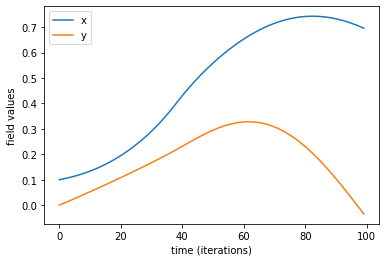

In [35]:
plt.plot(result["x"], label="x")
plt.plot(result["y"], label="y")
plt.xlabel("time (iterations)")
plt.ylabel("field values")
plt.legend()

The above plot shows the time evolution of the quantity *x* and *y*. The plot is not very meaningful, but at least we see that the values are well within the analog computer bounds $[-1,1]$.

Let's run the simulation a bit longer and display a *phase space* plot of *x* and *y*:

Running: ./a.out --max_iterations=30000 --modulo_write=50


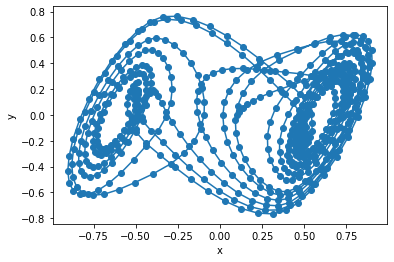

In [78]:
result = run(arguments={"max_iterations":30000, "modulo_write":50})
plt.xlabel("x"); plt.ylabel("y")
plt.plot(result["x"], result["y"], "o-")

That's it for the moment. If you want to see even more advanced plotting, inspect the `run-chua.py` file in the directory of this notebook file (i.a. in the `experiments/` directory).